<a href="https://colab.research.google.com/github/martinaluyten/Analysis-of-Big-Data-in-Physics/blob/main/Gravitational_wave_data_analysis_Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gravitational wave data analysis: Matched filter

# Assignment 1

In [ ]:
import sys
!{sys.executable} -m pip install pycbc ligo-common --no-cache-dir 

In [1]:
from pycbc.frame import read_frame
from pycbc.filter import highpass_fir, lowpass_fir
from pycbc.waveform import get_fd_waveform
from pycbc.psd import welch, interpolate
from pycbc.catalog import Merger
import pylab
from pycbc.types import  FrequencySeries, TimeSeries

from scipy import interpolate

import numpy as np
from pycbc import frame
import pycbc
from pycbc.filter import resample_to_delta_t, highpass
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from scipy.stats import norm 
from pycbc.detector import Detector
from scipy.interpolate import interp1d

import numpy as np

from pycbc.waveform import td_approximants, fd_approximants
import pylab
from pycbc import types 
from pycbc.filter import matched_filter
from pycbc.waveform import get_td_waveform

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#downloading the data set
d = np.load('/content/drive/MyDrive/Colab Notebooks/GW_noisedata-2.npy') 
dt = d[:, 0]
#comverting data into GW timeSeries
data_H1 = pycbc.types.TimeSeries(d[:, 1], delta_t = dt[1]- dt[0]) 
data_L1 = pycbc.types.TimeSeries(d[:, 2], delta_t = dt[1]- dt[0]) 
#merger = Merger("GW170817")
strain, stilde = {}, {}
#downsample the data at a sampling rate of 2048Hz & remove low frequency content
strain['H1'] = resample_to_delta_t(highpass(data_H1, 30.0), 1.0/2048)
strain['L1'] = resample_to_delta_t(highpass(data_L1, 30.0), 1.0/2048)

strain['H1'] = strain['H1'].crop(4, 4)
strain['L1'] = strain['L1'].crop(4, 4)

#frequency domain version of the data
stilde['H1'] = strain['H1'].to_frequencyseries()
stilde['L1'] = strain['L1'].to_frequencyseries()

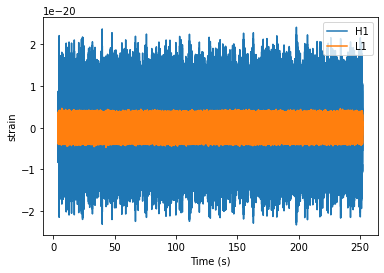

In [6]:
#plotting data
pylab.plot(strain['H1'].sample_times, strain['H1'], label= 'H1')
pylab.plot(strain['L1'].sample_times, strain['L1'], label= 'L1')
pylab.legend()
pylab.xlabel('Time (s)')
pylab.ylabel('strain')
pylab.show()

**Power Spectral Density**

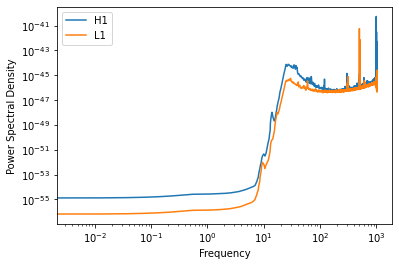

In [4]:
import pycbc.psd
from pycbc.psd import interpolate
psdsH1, psdsL1 = {},{}

delta_tH1 = strain['H1'].delta_t
delta_tL1 = strain['L1'].delta_t

seg_lenH1 = int(2/delta_tH1)
seg_lenL1 = int(2/delta_tL1)

seg_strideH1 = int(seg_lenH1/2)
seg_strideL1 = int(seg_lenL1/2)
psdsH1['H1']=pycbc.psd.welch(strain['H1'],seg_lenH1,seg_strideH1) 
psdsL1['L1']=pycbc.psd.welch(strain['L1'],seg_lenL1,seg_strideL1) 

psdsH1['H1']=interpolate(psdsH1['H1'],stilde['H1'].delta_f)
psdsL1['L1']=interpolate(psdsL1['L1'],stilde['L1'].delta_f)

pylab.loglog(psdsH1['H1'].sample_frequencies,psdsH1['H1'],label='H1')
pylab.loglog(psdsL1['L1'].sample_frequencies,psdsL1['L1'],label='L1')

pylab.xlabel("Frequency")
pylab.ylabel("Power Spectral Density")
pylab.legend()

#pylab.xlim[20,5000]
#pylab.ylim[1e-47,1e-24]


(1e-47, 1e-42)

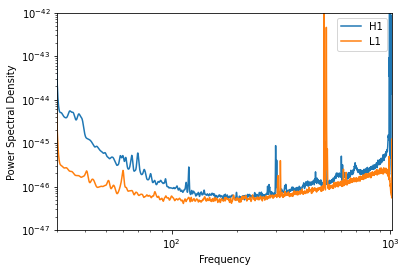

In [8]:
#controling the data that will be corrupted by overwhitening the data : chosing 2seconds
from pycbc.psd import interpolate, inverse_spectrum_truncation
psdsH1, psdsL1 = {}, {}
psdsH1['H1']=interpolate(strain['H1'].psd(2),stilde['H1'].delta_f)
psdsL1['L1']=interpolate(strain['L1'].psd(2),stilde['L1'].delta_f)

psdsH1['H1']=inverse_spectrum_truncation(psdsH1['H1'],int(2*strain['H1'].sample_rate),
                                                        low_frequency_cutoff=30,
                                                        trunc_method='hann')

psdsL1['L1']=inverse_spectrum_truncation(psdsL1['L1'],int(2*strain['L1'].sample_rate),
                                                        low_frequency_cutoff=30,
                                                        trunc_method='hann')

pylab.loglog(psdsH1['H1'].sample_frequencies,psdsH1['H1'],label='H1')
pylab.loglog(psdsL1['L1'].sample_frequencies,psdsL1['L1'],label='L1')

pylab.xlabel("Frequency")
pylab.ylabel("Power Spectral Density")
pylab.legend()

pylab.xlim(30,1024)
pylab.ylim(1e-47,1e-42)

**finding optimal mass**


In [9]:
#available approximants:
print(td_approximants())

['TaylorT1', 'TaylorT2', 'TaylorT3', 'SpinTaylorT1', 'SpinTaylorT4', 'SpinTaylorT5', 'PhenSpinTaylor', 'PhenSpinTaylorRD', 'EOBNRv2', 'EOBNRv2HM', 'TEOBResum_ROM', 'SEOBNRv1', 'SEOBNRv2', 'SEOBNRv2_opt', 'SEOBNRv3', 'SEOBNRv3_pert', 'SEOBNRv3_opt', 'SEOBNRv3_opt_rk4', 'SEOBNRv4', 'SEOBNRv4_opt', 'SEOBNRv4P', 'SEOBNRv4PHM', 'SEOBNRv2T', 'SEOBNRv4T', 'SEOBNRv4_ROM_NRTidalv2', 'SEOBNRv4_ROM_NRTidalv2_NSBH', 'HGimri', 'IMRPhenomA', 'IMRPhenomB', 'IMRPhenomC', 'IMRPhenomD', 'IMRPhenomD_NRTidalv2', 'IMRPhenomNSBH', 'IMRPhenomHM', 'IMRPhenomPv2', 'IMRPhenomPv2_NRTidal', 'IMRPhenomPv2_NRTidalv2', 'TaylorEt', 'TaylorT4', 'EccentricTD', 'SpinDominatedWf', 'NR_hdf5', 'NRSur7dq2', 'NRSur7dq4', 'SEOBNRv4HM', 'NRHybSur3dq8', 'IMRPhenomXAS', 'IMRPhenomXHM', 'IMRPhenomPv3', 'IMRPhenomPv3HM', 'IMRPhenomXP', 'IMRPhenomXPHM', 'TEOBResumS', 'IMRPhenomT', 'IMRPhenomTHM', 'IMRPhenomTP', 'IMRPhenomTPHM', 'TaylorF2', 'SEOBNRv1_ROM_EffectiveSpin', 'SEOBNRv1_ROM_DoubleSpin', 'SEOBNRv2_ROM_EffectiveSpin', 'SEOBN

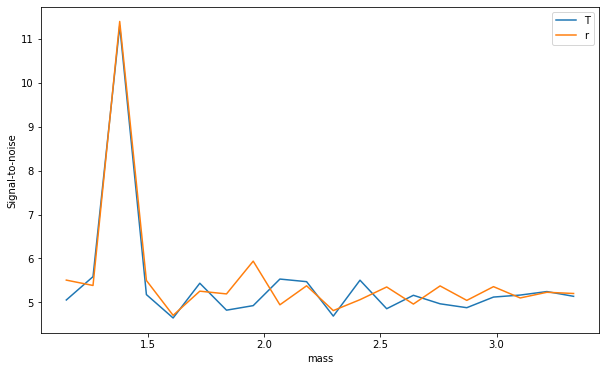

In [10]:
#finding the mass that gives the largest snr
from pycbc.inject import get_td_waveform
from pycbc.waveform.waveform import get_td_waveform_from_fd

from pycbc.waveform import get_fd_waveform
from pycbc.filter import matched_filter
from pycbc.conversions import mass1_from_mchirp_q
import numpy

#template waveform is produced from an equal mass binary system
#masses of the systems are uniformly distributed in a range 1M⊙ ≤ m1,2 ≤ 3M⊙

#trying with different masses
chirp_mass=numpy.arange(1,3,0.1)
mass1=mass1_from_mchirp_q(chirp_mass, 1)
mass2=mass1

#mass1=numpy.arange(1,3,0.10)
#mass2=mass1
hmax,smax,tmax,mmax,nsnr=None,{},{},0,0
snrsH1,snrsL1={},{}

#generating the template waveforms for matched filtering
Snr_list=[]
for i in range(len(mass1)):
  m=mass1[i]
  hp,hc=get_td_waveform(approximant='TaylorT2',
                                mass1=m,
                                mass2=m,
                                delta_t=1/2048,
                                f_lower=30)
  hp.resize(len(strain['H1']))
  template=hp.cyclic_time_shift(hp.start_time)
  snr=matched_filter(template,
                     strain['H1'],
                     psd=psdsH1['H1'],
                     low_frequency_cutoff=30)
  snrH1=snr.crop(4+4,4)
  Snr_list.append(max(abs(snrH1)))
snrsH1['H1']=Snr_list

Snr_list=[]
for i in range(len(mass1)):
  m=mass1[i]

  lp,lc=get_td_waveform(approximant='TaylorT2',
                                mass1=m,
                                mass2=m,
                                delta_t=1/2048,
                                f_lower=30)
  lp.resize(len(strain['L1']))
  template=lp.cyclic_time_shift(lp.start_time)
  snr=matched_filter(template,
                     strain['L1'],
                     psd=psdsL1['L1'],
                     low_frequency_cutoff=30)
  snrH1=snr.crop(4+4,4)
  Snr_list.append(max(abs(snrH1)))
snrsL1['L1']=Snr_list

#plot which shows the SNR versus total mass of the system
pylab.figure(figsize=[10,6])
x = mass1
y1 = snrsH1['H1']
y2 = snrsL1 ['L1']
pylab.plot(x,y1,label='H1')
pylab.plot(x,y2,label='L1')
pylab.legend('True')
pylab.ylabel('Signal-to-noise')
pylab.xlabel('mass')
pylab.show()

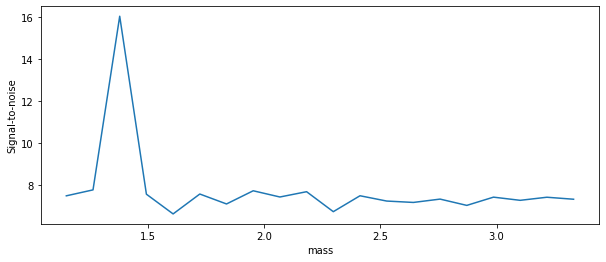

We found the best Mass1=Mass2 was 1.38 solar masses (detector frame)


In [11]:
#finding mass for which the signal to noise ratio is maximum + plotting
nsnr = (numpy.array(snrsH1['H1'])**2 + numpy.array(snrsL1['L1'])**2)**0.5
ii = numpy.where(nsnr == max(nsnr))
pylab.figure(figsize=[10, 4])
pylab.plot(mass1, nsnr)

pylab.ylabel('Signal-to-noise')
pylab.xlabel('mass')
pylab.show()

print("We found the best Mass1=Mass2 was %2.2f solar masses (detector frame)" % mass1[ii])

with mass1=numpy.arange(1,3,0.10) the the best mass is 1.40 solar masses with SNR=8.2

with chirp_mass=numpy.arange(1,3,0.1), mass1=mass1_from_mchirp_q(chirp_mass, 1) the best mass is 1.38 with SNR=16

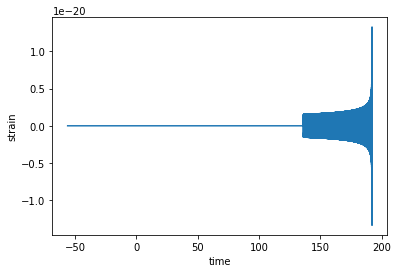

In [23]:
m = 1.38
conditioned = strain['H1']
hp, hc = get_td_waveform(approximant='TaylorT2',
                     mass1=m,
                     mass2=m,
                     delta_t=conditioned.delta_t,
                     f_lower=30)
hp.resize(len(conditioned))

template = hp .cyclic_time_shift(hp.start_time)
pylab.plot(hp.sample_times, template)
pylab.xlabel('time')
pylab.ylabel('strain')
pylab.show()

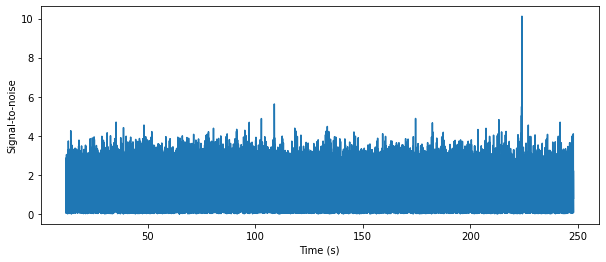

We found a signal at 224.0244140625s with SNR 10.117617289422226


In [25]:
from pycbc.psd import interpolate, inverse_spectrum_truncation
#Estimate the power spectral density
#psd = strain['L1'].psd(2)
#psd = interpolate(psd, strain['L1'].delta_f)
#psd = inverse_spectrum_truncation(psd, int(2 * strain['L1'].sample_rate),
                                  #low_frequency_cutoff=30)
conditioned = strain['L1']
snr = matched_filter(template,conditioned, psd=psdsL1['L1'] , low_frequency_cutoff=30)
#snr = matched_filter(template, strain['L1'],psd=psd, low_frequency_cutoff=30)
snr = snr.crop(4 + 4, 4)

pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time,abs(snrp)))
                        
#pylab.loglog(psd.sample_frequencies, psd)
#pylab.ylabel('$Strain^2 / Hz$')
#pylab.xlabel('Frequency (Hz)')
#pylab.xlim(30, 1024)


In [26]:
from pycbc.filter import sigma
dt = time - strain['L1'].start_time
aligned = template.cyclic_time_shift(dt)
aligned /= sigma(aligned, psd=psdsL1['L1'], low_frequency_cutoff=30)
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries()
aligned.start_time = strain['L1'].start_time

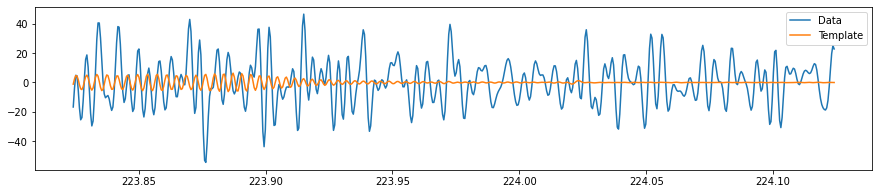

In [32]:
# We do it this way so that we can whiten both the template and the data
white_data = (conditioned.to_frequencyseries() / psdsL1['L1']**0.5).to_timeseries()

# apply a smoothing of the turnon of the template to avoid a transient
# from the sharp turn on in the waveform.
tapered = aligned.highpass_fir(30, 512, remove_corrupted=False)
white_template = (tapered.to_frequencyseries() / psdsL1['L1']**0.5).to_timeseries()

white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)
white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

# Select the time around the merger
white_data = white_data.time_slice(time-.2,time+.1)
white_template = white_template.time_slice(time-.2,time+.1)

pylab.figure(figsize=[15, 3])
pylab.plot(white_data.sample_times, white_data, label="Data")
pylab.plot(white_template.sample_times, white_template, label="Template")
pylab.legend()
#pylab.xlim(220, 224)
pylab.show()

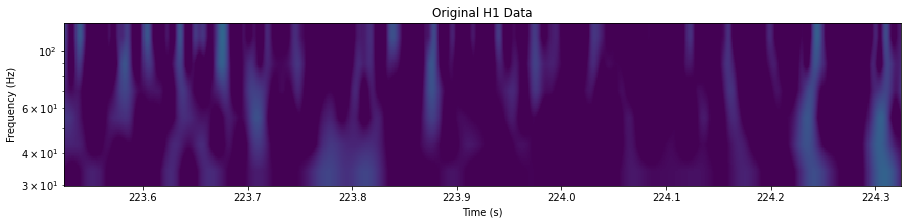

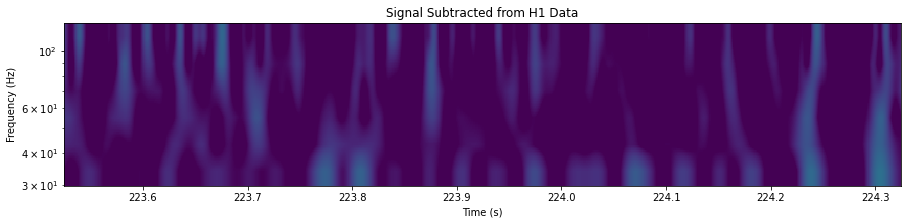

In [33]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
subtracted = conditioned - aligned
for data, title in [(conditioned, 'Original H1 Data'),
                    (subtracted, 'Signal Subtracted from H1 Data')]:
                    t, f, p=data.whiten(4,4).qtransform(.001,
                                                              logfsteps=100,
                                                              qrange=(4,4),
                                                              frange=(30,128))
                    pylab.figure(figsize=[15, 3])
                    pylab.title(title)
                    pylab.pcolormesh(t, f, p**0.5,vmin=1, vmax=6)
                    #pylab.pcolormesh(t, f, p**0.5)
                    pylab.yscale('log')
                    pylab.xlabel('Time (s)')
                    pylab.ylabel('Frequency (Hz)')
                    pylab.xlim(time-0.5,time+0.3)
                    pylab.show()

**Correlation in the parameter space of gravitational waves from compact binary coalescences**

In [34]:
from pycbc.waveform import get_td_waveform
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower

In [35]:
from pyparsing.helpers import MatchFirst
import pandas as pd

f_low=30
sample_rate=2048

masses = np.arange(5,15,0.1)
matches = {}

for mass in masses:
  #gravitational wave h* generated from a binary with masses m1 = m2 = 10M⊙
  hp, hc=get_td_waveform(approximant='TaylorT4',
                       mass1=10,
                       mass2=10,
                       f_lower=f_low,
                       delta_t=1/sample_rate)

  #nearby templates h_t that are generated assuming 5M⊙ ≤ m1,m2 ≤ 15M⊙
  sp,sc=get_td_waveform(approximant='TaylorT4',
                          mass1=mass,
                          mass2=mass,
                          f_lower=f_low,
                          delta_t=1/sample_rate)
  
  tlen=max(len(sp),len(hp))
  sp.resize(tlen)
  hp.resize(tlen)
  
  delta_f1 = 1.0/sp.duration
  flen=tlen//2+1
  psd=aLIGOZeroDetHighPower(flen,delta_f1,f_low)
  
  #calculating the match between h* and h_t
  m,i = match(hp,sp,psd=psd,low_frequency_cutoff=f_low)
  matches[mass]=m


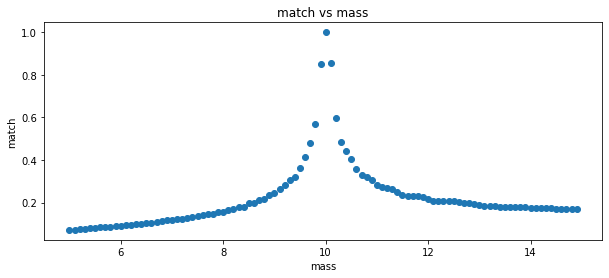

In [36]:
x=masses
y=matches.values()
pylab.figure(figsize=[10,4])
pylab.scatter(x,y)
pylab.title('match vs mass')
pylab.ylabel('match')
pylab.xlabel('mass')
pylab.show()

match found where h* = h_t (match=1) at m = 10 solar masses --> gravitational waveforms are correlated for two nearby points in the parameter space
